In [143]:
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
import numpy as np
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
import galsim
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import SingleGalsimGalaxyDecoder,SingleGalsimGalaxyPrior,UniformGalsimGalaxiesPrior
from bliss.datasets.galsim_galaxies import GalsimBlends
from case_studies.coadds.signal_noise_ratio  import snr


In [14]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [161]:
def _add_noise_and_background(image: Tensor, background: Tensor) -> Tensor:
    image_with_background = image + background
    noise = image_with_background.sqrt() * torch.randn_like(image_with_background)
    return image_with_background + noise

def load_psf_from_file(psf_image_file: str, pixel_scale: float) -> galsim.GSObject:
    """Return normalized PSF galsim.GSObject from numpy psf_file."""
    assert Path(psf_image_file).suffix == ".npy"
    psf_image = np.load(psf_image_file)
    assert len(psf_image.shape) == 3 and psf_image.shape[0] == 1
    psf_image = galsim.Image(psf_image[0], scale=pixel_scale)
    return galsim.InterpolatedImage(psf_image).withFlux(1.0)

def _sample_n_sources(max_n_sources) -> int:
    return int(torch.randint(1, max_n_sources + 1, (1,)).int().item())

def _uniform(a, b, n_samples=1) -> Tensor:
    # uses pytorch to return a single float ~ U(a, b)
    return (a - b) * torch.rand(n_samples) + b

class CoaddUniformGalsimGalaxiesPrior(UniformGalsimGalaxiesPrior):
    def __init__(
        self,
        single_galaxy_prior: SingleGalsimGalaxyPrior,
        max_n_sources: int,
        max_shift: float,
        num_dithers: int,
    ):
        super().__init__(
            single_galaxy_prior,
            max_n_sources,
            max_shift,
        )
        
    def sample(self) -> Dict[str, Tensor]:
        """Returns a single batch of source parameters."""
        n_sources = _sample_n_sources(self.max_n_sources)

        params = torch.zeros(self.max_n_sources, self.dim_latents)
        params[:n_sources, :] = self.single_galaxy_prior.sample(n_sources)

        locs = torch.zeros(self.max_n_sources, 2)
        locs[:n_sources, 0] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5
        locs[:n_sources, 1] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5

        # for now, galaxies only
        galaxy_bools = torch.zeros(self.max_n_sources, 1)
        galaxy_bools[:n_sources, :] = 1
        star_bools = torch.zeros(self.max_n_sources, 1)

        dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(num_dithers)]

        return {
            "n_sources": torch.tensor(n_sources),
            "galaxy_params": params,
            "locs": locs,
            "galaxy_bools": galaxy_bools,
            "star_bools": star_bools,
            "dithers": dithers,
        }

class CoaddSingleGalaxyDecoder(SingleGalsimGalaxyDecoder):
    def __init__(
        self,
        slen: int,
        n_bands: int,
        pixel_scale: float,
    #    psf_image_file: str,
     ) -> None:
        assert n_bands == 1, "Only 1 band is supported"
        self.slen = slen
        self.n_bands = 1
        self.pixel_scale = pixel_scale
    #    self.psf = load_psf_from_file(psf_image_file, self.pixel_scale)
        
    def render_galaxy(
        self,
        galaxy_params: Tensor,
        psf: galsim.GSObject,
        slen: int,
        offset: Optional[Tensor] = None,
        dithers: Optional[Tensor] = None,
    ) -> Tensor:
        assert offset is None or offset.shape == (2,)
        if isinstance(galaxy_params, Tensor):
            galaxy_params = galaxy_params.cpu().detach()
        total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
        bulge_frac = 1 - disk_frac

        disk_flux = total_flux * disk_frac
        bulge_flux = total_flux * bulge_frac

        components = []
        if disk_flux > 0:
            b_d = a_d * disk_q
            disk_hlr_arcsecs = np.sqrt(a_d * b_d)
            disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
                q=disk_q,
                beta=beta_radians * galsim.radians,
            )
            components.append(disk)
        if bulge_flux > 0:
            b_b = bulge_q * a_b
            bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
            bulge = galsim.DeVaucouleurs(
                flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
            ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
            components.append(bulge)
        galaxy = galsim.Add(components)
        gal_conv = galsim.Convolution(galaxy, psf)
        offset = (0,0) if offset is None else offset
        dithers = (0,0) if dithers is None else dithers
        shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
        shift = shift.reshape(1,2) if len(shift) == 2 else shift
        images = []
        for i in shift:
            image = gal_conv.drawImage(
                nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
            )
            image = image.array
            images.append(image)
        return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

class FullCatalogDecoder:
    def __init__(
        self, single_galaxy_decoder: CoaddSingleGalaxyDecoder, slen: int, bp: int
    ) -> None:
        self.single_decoder = single_galaxy_decoder
        self.slen = slen
        self.bp = bp
        assert self.slen + 2 * self.bp >= self.single_decoder.slen

    def __call__(self, full_cat: FullCatalog):
        return self.render_catalog(full_cat, self.single_decoder.psf)

    def render_catalog(self, full_cat: FullCatalog, psf: galsim.GSObject, dithers: Optional[Tensor]):
        size = decoder.slen + 2 * bp
        full_plocs = full_catalog.plocs
        b, max_n_sources, _ = full_plocs.shape

        image = torch.zeros(len(dithers), 1, size, size)
        image0 = torch.zeros(1, size, size)
        noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
        noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

        n_sources = int(full_cat.n_sources[0].item())
        galaxy_params = full_cat["galaxy_params"][0]
        plocs = full_plocs[0]

        for ii in range(n_sources):
            offset_x = plocs[ii][1] + bp - size / 2
            offset_y = plocs[ii][0] + bp - size / 2
            offset = torch.tensor([offset_x, offset_y])
            centered = self.single_decoder.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
            uncentered = self.single_decoder.render_galaxy(galaxy_params[ii], psf, size, offset)
            uncentered_dithered = self.single_decoder.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
            noiseless_centered[:,ii] = centered.reshape(centered.shape[0], 1, size, size)
            noiseless_uncentered[:,ii] = uncentered.reshape(uncentered.shape[0], 1, size, size)
            image0 += uncentered
            image += uncentered_dithered
        return image, noiseless_centered, noiseless_uncentered, image0


class CoaddGalsimBlends(GalsimBlends):
    """Dataset of coadd galsim blends."""

    def __init__(self,
        prior: UniformGalsimGalaxiesPrior,
        decoder: FullCatalogDecoder,
        background: ConstantBackground,
        tile_slen: int,
        max_sources_per_tile: int,
        num_workers: int,
        batch_size: int,
        n_batches: int,
        fix_validation_set: bool = False,
        valid_n_batches: Optional[int] = None,
    ):
        super().__init__(
            prior,
            decoder,
            background,
            tile_slen,
            max_sources_per_tile,
            num_workers,
            batch_size,
            n_batches,
            fix_validation_set,
            valid_n_batches,
        )
        self.prior = prior
        self.decoder = decoder
        self.n_batches = n_batches
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.background = background
        self.fix_validation_set = fix_validation_set
        self.valid_n_batches = valid_n_batches
        
        self.slen = self.decoder.slen
        self.pixel_scale = self.decoder.single_decoder.pixel_scale
        

    def _get_images(self, full_cat, dithers):
        size = self.slen + 2 * self.bp # check bp gets passed through
        psf_obj = self.psf.sample()
        noiseless, noiseless_centered, noiseless_uncentered, image0 = FullCatalogDecoder.render_catalog(
            full_cat, psf_obj, dithers
        )

        # get background and noisy image.
        background = background.sample((1, *noiseless.reshape(len(dithers),size,size).shape)).squeeze(0).reshape(len(dithers),1,size,size)
        noisy_image = _add_noise_and_background(noiseless, background)

        # align single exposures
        aligned_images = align_single_exposures(image0[:].reshape(size,size), noisy_image, size, dithers)
        
        # get snr
        bg = background[:,:, 1:size-1, 1:size-1]
        img = aligned_images.reshape(len(dithers),1,size-2,size-2)
        snr_images = snr(img, bg)

        # coadd images
        cropped_background = background.reshape(len(dithers),size,size)[:,1:size-1, 1:size-1] 
        coadded_image = linear_coadd(aligned_images, cropped_background)

        return noisy_image, noiseless, noiseless_centered, noiseless_uncentered, background, snr_images, coadded_image

    def _add_metrics(
        self,
        full_cat: FullCatalog,
    ):
        return full_cat




In [4]:
with initialize(config_path="../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [5]:
prior = instantiate(cfg.datasets.sdss_galaxies.prior) 
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
n_batches = 1
max_n_sources = 1
max_shift = 0.5
num_dithers = 4
mprior = instantiate(cfg.models.prior)
tile_catalog = mprior.sample_prior(tile_slen=4, batch_size=3, n_tiles_h=2, n_tiles_w=2)
full_catalog = TileCatalog.to_full_params(tile_catalog)

In [6]:
# Test CUGGP
cuggp = CoaddUniformGalsimGalaxiesPrior(prior, max_n_sources, max_shift, num_dithers)


In [7]:
pixel_scale = 0.393
cuggprior = cuggp.sample() # does not work if we use galsim_blended_galaxies for prior config
n_sources = cuggprior["n_sources"]
galaxy_params = cuggprior["galaxy_params"]
locs = cuggprior["locs"]
galaxy_bools = cuggprior["galaxy_bools"]
star_bools = cuggprior["star_bools"]
dithers = cuggprior["dithers"]
offset = None
psf = decoder.psf


In [34]:
dithers

[array([-0.4811225 , -0.21159571], dtype=float32),
 array([-0.34641796, -0.29002923], dtype=float32),
 array([-0.32266533, -0.25221276], dtype=float32),
 array([-0.09234637, -0.26480418], dtype=float32)]

In [8]:
csgd = CoaddSingleGalaxyDecoder(decoder, n_bands = 1, pixel_scale = pixel_scale)
csgd.render_galaxy(galaxy_params = galaxy_params[0], slen = decoder.slen, psf = decoder.psf, offset = offset, dithers = dithers)

/tmp/ipykernel_1476522/2304180995.py:113: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))


tensor([[[[0.0261, 0.0277, 0.0293,  ..., 0.0304, 0.0287, 0.0271],
          [0.0275, 0.0293, 0.0311,  ..., 0.0321, 0.0303, 0.0285],
          [0.0291, 0.0309, 0.0329,  ..., 0.0340, 0.0319, 0.0300],
          ...,
          [0.0317, 0.0337, 0.0359,  ..., 0.0315, 0.0296, 0.0278],
          [0.0301, 0.0319, 0.0339,  ..., 0.0298, 0.0280, 0.0264],
          [0.0285, 0.0302, 0.0320,  ..., 0.0282, 0.0266, 0.0250]]],


        [[[0.0255, 0.0271, 0.0287,  ..., 0.0309, 0.0291, 0.0275],
          [0.0269, 0.0286, 0.0304,  ..., 0.0327, 0.0308, 0.0290],
          [0.0284, 0.0302, 0.0322,  ..., 0.0345, 0.0325, 0.0305],
          ...,
          [0.0312, 0.0332, 0.0353,  ..., 0.0323, 0.0303, 0.0285],
          [0.0296, 0.0314, 0.0334,  ..., 0.0305, 0.0287, 0.0270],
          [0.0281, 0.0297, 0.0315,  ..., 0.0288, 0.0271, 0.0256]]],


        [[[0.0262, 0.0277, 0.0294,  ..., 0.0303, 0.0286, 0.0270],
          [0.0276, 0.0293, 0.0312,  ..., 0.0320, 0.0302, 0.0284],
          [0.0292, 0.0310, 0.0330,  ..

In [9]:
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = CoaddGalsimBlends(prior = prior, decoder = decoder, background = background, tile_slen = tile_slen, max_sources_per_tile = max_tile_n_sources, num_workers = num_workers, batch_size = batch_size, n_batches = n_batches)._sample_full_catalog()

In [10]:
slen = 40
bp = 24
fcdecoder = FullCatalogDecoder(decoder, slen, bp)
fcdecoder.render_catalog(full_catalog, psf, dithers) # Do I need to change the target in config to bliss.case_study.coadd.coadd_decoder?

RuntimeError: output with shape [1, 88, 88] doesn't match the broadcast shape [1, 1, 88, 88]

In [48]:
dithers

[array([ 0.2863866, -0.2431587], dtype=float32),
 array([0.45234668, 0.29335123], dtype=float32),
 array([0.26052737, 0.14739156], dtype=float32),
 array([-0.45585835,  0.38580644], dtype=float32)]

In [11]:
total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params[0]
bulge_frac = 1 - disk_frac

disk_flux = total_flux * disk_frac
bulge_flux = total_flux * bulge_frac

components = []
if disk_flux > 0:
    b_d = a_d * disk_q
    disk_hlr_arcsecs = np.sqrt(a_d * b_d)
    disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
        q=disk_q,
        beta=beta_radians * galsim.radians,
    )
    components.append(disk)
if bulge_flux > 0:
    b_b = bulge_q * a_b
    bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
    bulge = galsim.DeVaucouleurs(
        flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
    ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
    components.append(bulge)
galaxy = galsim.Add(components)
gal_conv = galsim.Convolution(galaxy, psf)
offset = (0,0) if offset is None else offset
dithers = (0,0) if dithers is None else dithers
shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
shift = shift.reshape(1,2) if len(shift) == 2 else shift
images = []
for i in shift:
    image = gal_conv.drawImage(
        nx=slen, ny=slen, method="auto", scale=pixel_scale, offset=i
    )
    image = image.array
    images.append(image)
torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)


tensor([[[[0.0590, 0.0634, 0.0682,  ..., 0.0695, 0.0646, 0.0601],
          [0.0631, 0.0681, 0.0735,  ..., 0.0746, 0.0692, 0.0641],
          [0.0675, 0.0731, 0.0792,  ..., 0.0801, 0.0740, 0.0684],
          ...,
          [0.0733, 0.0794, 0.0859,  ..., 0.0749, 0.0692, 0.0639],
          [0.0686, 0.0740, 0.0798,  ..., 0.0697, 0.0646, 0.0599],
          [0.0641, 0.0689, 0.0741,  ..., 0.0649, 0.0603, 0.0561]]],


        [[[0.0574, 0.0617, 0.0664,  ..., 0.0708, 0.0659, 0.0613],
          [0.0614, 0.0662, 0.0714,  ..., 0.0761, 0.0706, 0.0655],
          [0.0656, 0.0710, 0.0769,  ..., 0.0818, 0.0756, 0.0699],
          ...,
          [0.0717, 0.0777, 0.0841,  ..., 0.0771, 0.0712, 0.0657],
          [0.0672, 0.0725, 0.0782,  ..., 0.0717, 0.0664, 0.0616],
          [0.0629, 0.0677, 0.0727,  ..., 0.0667, 0.0620, 0.0576]]],


        [[[0.0592, 0.0637, 0.0684,  ..., 0.0692, 0.0644, 0.0599],
          [0.0634, 0.0684, 0.0738,  ..., 0.0743, 0.0689, 0.0639],
          [0.0678, 0.0734, 0.0795,  ..

In [28]:
size = decoder.slen + 2 * bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
noiseless_centered = torch.zeros(max_n_sources, len(dithers), size, size)
noiseless_uncentered = torch.zeros(max_n_sources, len(dithers), size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[ii] = centered.reshape(centered.shape[0], size, size)
    noiseless_uncentered[ii] = uncentered.reshape(uncentered.shape[0], size, size)
    image += uncentered

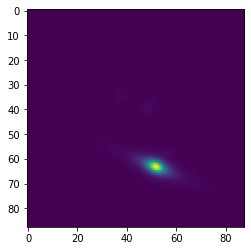

In [15]:
plt.imshow(image[2].reshape(image[2].shape[1],image[2].shape[2]).numpy())

In [30]:
centered.reshape(centered.shape[0], size, size).shape

torch.Size([4, 88, 88])

In [29]:
noiseless_uncentered.shape

torch.Size([6, 4, 88, 88])

In [32]:
noiseless_centered.shape

torch.Size([4, 6, 1, 88, 88])

In [36]:
image = torch.zeros(len(dithers), 1, size, size)
image0 = torch.zeros(1, 1, size, size)
noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset)
    uncentered_dithered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[:,ii] = centered.reshape(centered.shape[0], 1, size, size)
    noiseless_uncentered[:,ii] = uncentered.reshape(uncentered.shape[0], 1, size, size)
    image0 += uncentered
    image += uncentered_dithered

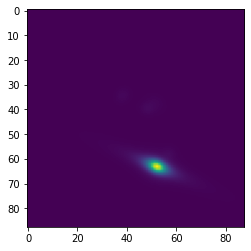

In [33]:
plt.imshow(image0[:].reshape(image0[:].shape[2],image0[:].shape[3]).numpy())

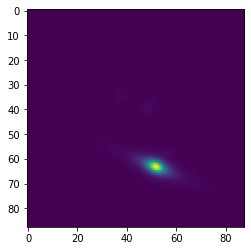

In [34]:
plt.imshow(image[2].reshape(image[2].shape[1],image[2].shape[2]).numpy())

In [69]:
# check noise and dither independence
background = instantiate(cfg.datasets.sdss_galaxies.background)
background = background.sample((1, *image.reshape(len(dithers),size,size).shape)).squeeze(0).reshape(len(dithers),1,size,size)
_add_noise_and_background(image, background)

image_with_background = image + background
noise = image_with_background.sqrt() * torch.randn_like(image_with_background) # randomized by value of Tensor
noisy_image = image_with_background + noise

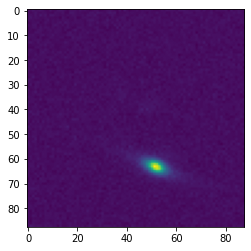

In [70]:
plt.imshow(noisy_image[2].reshape(noisy_image[2].shape[1],noisy_image[2].shape[2]).numpy())

In [40]:
i0 = galsim.Image(np.array(image0[:].reshape(88,88)), wcs=galsim.PixelScale(pixel_scale))
i1 = galsim.Image(np.array(image[:][0].reshape(88,88)))

In [146]:
from bliss.models.decoder import get_mgrid
def align_single_exposures(img0, img1, slen, dithers):
    img0 = galsim.Image(np.array(img0), wcs=galsim.PixelScale(pixel_scale))
    wcs0 = img0.wcs
    images = img1

    sgrid = (get_mgrid(slen) - (-1))/(1-(-1)) * (slen)
    grid_x = wcs0.xyTouv(np.array(sgrid.reshape(slen*slen,2)[:,0]), np.array(sgrid.reshape(slen*slen,2)[:,1]))[0]
    grid_y = wcs0.xyTouv(np.array(sgrid.reshape(slen*slen,2)[:,0]), np.array(sgrid.reshape(slen*slen,2)[:,1]))[1]

    grid = torch.empty(size=(0, 2))
    for i in dithers:
        wcs1 = galsim.OffsetWCS(scale = 0.393, origin = galsim.PositionD(i))
        x, y = wcs1.uvToxy(grid_x,grid_y)
        x_grid = (x/slen) * (1-(-1)) + (-1)
        y_grid = (y/slen) * (1-(-1)) + (-1)
        grid = torch.cat([grid, torch.stack((torch.tensor(x_grid),torch.tensor(y_grid)),-1)], dim=0)

    iplots = []
    input = torch.tensor(images[:]).reshape(len(dithers),1,slen,slen).float()
    grids = grid.reshape(len(dithers),1,slen*slen,2).float()
    iplots.append(F.grid_sample(input, grids, align_corners = False))
    
    tenplot = torch.tensor(iplots[:][0])
    crop_images = []
    for i in range(tenplot.shape[0]):
        im = np.array(tenplot[i].reshape(slen,slen))
        crop_im = im[1:slen-1, 1:slen-1]
        crop_images.append(crop_im)
    return torch.tensor(crop_images)

In [79]:
image0[:].reshape(size,size)

torch.Size([4, 1, 88, 88])

In [147]:
# Add alignment and coadding 
img0 = image0[:].reshape(size,size)
imgs = noisy_image
aligned_images = align_single_exposures(img0, imgs, size, dithers)

/tmp/ipykernel_1476522/2364702946.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers),1,slen,slen).float()
/tmp/ipykernel_1476522/2364702946.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tenplot = torch.tensor(iplots[:][0])


In [154]:
(img - bg)**2

tensor([[[[9.7805e+01, 9.6151e+01, 3.9720e+02,  ..., 9.0323e+00,
           3.6585e-03, 7.2454e+02],
          [3.9433e+02, 2.5478e-03, 1.5205e+02,  ..., 2.7555e+00,
           1.2360e+02, 3.3436e+02],
          [5.9419e+02, 1.2934e+03, 7.0913e+01,  ..., 3.8722e+02,
           8.2502e+02, 5.9722e+01],
          ...,
          [9.7152e+02, 2.0778e+00, 1.5914e-01,  ..., 1.3392e+02,
           3.7324e+00, 7.0764e+02],
          [8.7064e+01, 4.1115e+02, 1.0128e+02,  ..., 9.6943e+02,
           7.1756e+02, 5.2908e+02],
          [8.2079e+01, 5.3716e+02, 1.0371e+03,  ..., 1.3515e+00,
           5.4402e+02, 3.5942e+01]]],


        [[[3.1136e+02, 2.6949e+03, 8.4436e+02,  ..., 1.2553e+02,
           2.2501e+02, 3.5207e+02],
          [8.3968e+02, 2.4448e+01, 1.1243e+03,  ..., 7.9012e+02,
           7.5952e+02, 3.3538e+03],
          [6.4019e+02, 6.7382e+01, 1.0354e+03,  ..., 9.4144e-01,
           1.5840e+01, 3.3410e+01],
          ...,
          [1.2033e+02, 6.9448e+01, 1.5404e+02,  ..., 1.16

In [158]:
# add snr
bg = background[:,:, 1:size-1, 1:size-1]
img = aligned_images.reshape(len(dithers),1,size-2,size-2)
img - bg
torch.sqrt(torch.sum((img - bg)**2 / (img - bg + bg), dim=(3, 2, 1)))
snr(img, bg)

tensor([233.6457, 236.4383, 232.0970, 232.5419])

In [130]:
# Coadd using direct coadd: linear combination 
# Direct coadd, where weights are proportional to inverse variance
bd = background.reshape(len(dithers),size,size)[:,1:size-1, 1:size-1] # background cropped
id = torch.tensor(aligned_images) - bd # aligned images without background
weight = 1 / torch.tensor(aligned_images)
num = torch.sum(id / torch.tensor(aligned_images), dim = 0)
coadded = num / (torch.sum(weight, dim = 0))

def linear_coadd(aligned_images, cropped_background):
    assert torch.tensor(aligned_images).shape == torch.tensor(cropped_background).shape

    id = torch.tensor(aligned_images) - cropped_background 
    weight = 1 / torch.tensor(aligned_images)
    num = torch.sum(id / torch.tensor(aligned_images), dim = 0)
    return num / (torch.sum(weight, dim = 0))


In [131]:
linear_coadd(aligned_images, bd)

/tmp/ipykernel_1476522/3013547580.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert torch.tensor(aligned_images).shape == torch.tensor(cropped_background).shape


tensor([[-14.4965,   5.7448,  15.6396,  ...,   9.7780,  11.7710,   0.6030],
        [  5.5216,   2.2028,   8.4663,  ...,  -5.4049,  -2.6983, -17.1500],
        [ 15.7054,  11.8200,  -3.8945,  ...,  -0.3650,   3.6645,  -0.4348],
        ...,
        [-19.0546,  -7.2267,  -4.5730,  ...,   7.0405, -22.6021, -22.1054],
        [  3.1368, -11.8408,  -3.5431,  ...,  -1.0711,  -5.2976,   8.3232],
        [-21.7410,  -2.5716,  -7.8379,  ...,   1.4767, -19.2051,  -1.5259]])

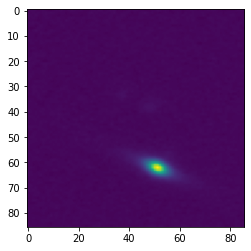

In [129]:
plt.imshow(coadded.numpy())

In [142]:
bd.shape

torch.Size([4, 86, 86])